In [16]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization, Add
from tensorflow.keras import Model
from tensorflow.keras.regularizers import L2
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

In [17]:
y_img_size = 128

In [18]:
def psnr(orig, pred):
	# crop the image (take image center part)
	margin = int(y_img_size / 4)
	orig = orig[margin:y_img_size-margin, margin:y_img_size-margin]
	pred = pred[margin:y_img_size-margin, margin:y_img_size-margin]
	# cast the target images to integer
	orig = orig * 255.0
	orig = tf.cast(orig, tf.uint8)
	orig = tf.clip_by_value(orig, 0, 255)
	# cast the predicted images to integer
	pred = pred * 255.0
	pred = tf.cast(pred, tf.uint8)
	pred = tf.clip_by_value(pred, 0, 255)
	# return the psnr
	return tf.image.psnr(orig, pred, max_val=255)

In [19]:
def scale_and_normalize(img, size):
    if (img.shape[0] != size or img.shape[1] != size):
        img = cv2.resize(img, (size, size))
    return img / 255

In [29]:
class CenterImagePriorityLoss(tf.keras.losses.Loss):

  # Defines the multiplication of a center MSE over a total MSE 
  cmr = 1
  # Defines the center area ratio: example car=0.5 means the center area size will be 1/2 of the image H and W  
  car = 0.5

  def __init__(self, reduction, name):
    super().__init__()
    self.cmr = 2
    self.car = 0.65
  
  def call(self, y_true, y_pred):
    
    # Calculate MSE of the full image
    full_img_mse = tf.reduce_mean(tf.square(y_pred-y_true))

    # Calculate MSE of center area
    margin = int(y_img_size * (1.0-self.car) / 2)
    y_true = y_true[:,margin:y_img_size-margin, margin:y_img_size-margin,:]
    y_pred = y_pred[:,margin:y_img_size-margin, margin:y_img_size-margin,:]
    center_img_mse = tf.reduce_mean(tf.square(y_pred-y_true))

    # Calculate final MSE 
    return (full_img_mse + center_img_mse*(self.cmr-1)) / self.cmr

In [30]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

model = tf.keras.models.load_model('../model_f1', custom_objects={'psnr':psnr, 'CenterImagePriorityLoss': CenterImagePriorityLoss})

1/1 [==============================] - 0s 53ms/step


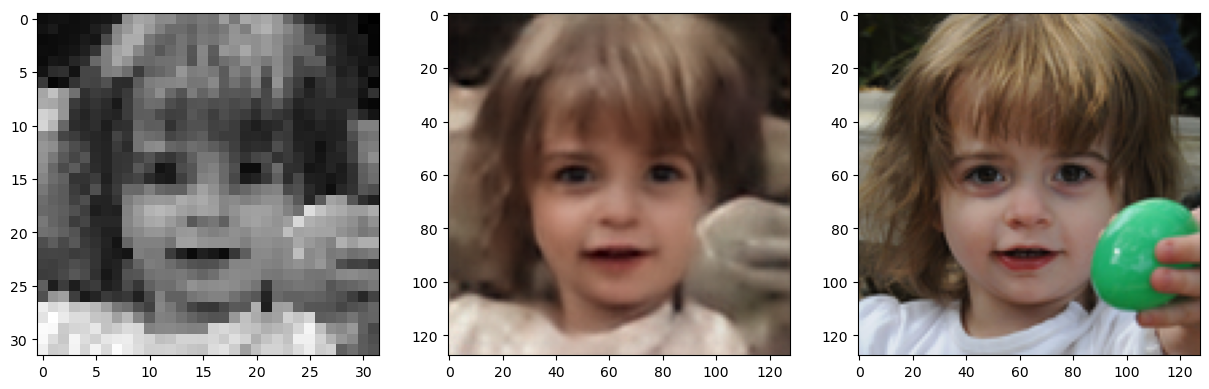

In [99]:

orig = cv2.imread('../data/test/69000/69309.png')

orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
x = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
x = scale_and_normalize(x, 32)

l = []
l.append(x)

y = model.predict(np.array(l))

f, axarr = plt.subplots(1,3)
axarr[0].imshow(x, cmap='gray')
axarr[1].imshow(np.array(y[0]))
axarr[2].imshow(orig)
